### Part2 - Using the COCO dataset

In [11]:
# !pip install pycocotools

Defaulting to user installation because normal site-packages is not writeable
  Using cached Pillow-10.1.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.5 kB)
Using cached Pillow-10.1.0-cp311-cp311-manylinux_2_28_x86_64.whl (3.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trdg 1.8.0 requires opencv-python>=4.2.0.32, which is not installed.


In [3]:
from pycocotools.coco import COCO

### Load the COCO dataset (cocotrain-2017)
we load the coc databse and then extract the id for cat and horse (17,19).\
Then we load the images for each category, to prevent overfiting we shuffle the data and divide them to train and test data.\
The next step is to add the label and Image into a datasource object and pass it to the model and train it.

In [4]:
coco = COCO(annotation_file="/scratch/lt2316-h18-resources/coco/annotations/instances_train2017.json")

loading annotations into memory...
Done (t=18.87s)
creating index...
index created!


In [5]:
cat_cat = coco.getCatIds(catNms="cat")
horse_cat = coco.getCatIds(catNms="horse")

In [6]:
horse_cat

[19]

In [24]:
cat_cat

[17]

In [8]:
cat_imgs = coco.getImgIds(catIds=cat_cat)
cat_imgs
horse_imgs = coco.getImgIds(catIds=horse_cat)

In [9]:
import random

random.shuffle(cat_imgs)
cat_imgs_train = cat_imgs[:400]
cat_imgs_test = cat_imgs[400:600]

random.shuffle(horse_imgs)
horse_imgs_train = horse_imgs[:400]
horse_imgs_test = horse_imgs[400:600]

In [10]:
cat_meta_train = coco.loadImgs(ids=cat_imgs_train)
cat_meta_test = coco.loadImgs(ids=cat_imgs_test)
horse_meta_train = coco.loadImgs(ids=horse_imgs_train)
horse_meta_test = coco.loadImgs(ids=horse_imgs_test)

In [11]:
cat_meta_train

[{'license': 3,
  'file_name': '000000299066.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000299066.jpg',
  'height': 440,
  'width': 640,
  'date_captured': '2013-11-16 15:04:32',
  'flickr_url': 'http://farm4.staticflickr.com/3401/3311805393_7c475a4aa9_z.jpg',
  'id': 299066},
 {'license': 1,
  'file_name': '000000351566.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000351566.jpg',
  'height': 640,
  'width': 480,
  'date_captured': '2013-11-17 20:12:59',
  'flickr_url': 'http://farm5.staticflickr.com/4104/5185340095_6c3dbdb64a_z.jpg',
  'id': 351566},
 {'license': 2,
  'file_name': '000000300244.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000300244.jpg',
  'height': 325,
  'width': 500,
  'date_captured': '2013-11-17 21:18:34',
  'flickr_url': 'http://farm3.staticflickr.com/2280/2194982738_be44a4638b_z.jpg',
  'id': 300244},
 {'license': 3,
  'file_name': '000000328069.jpg',
  'coco_url': 'http://images.cocodataset.org/train20

### Prepare Image 
##### Here we try to show an image and convert it to a PIL Image, to be aligned with the type we used in the first part

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("/scratch/lt2316-h18-resources/coco/train2017/{}".format(cat_meta_train[0]['file_name']))


In [29]:
type(img)

numpy.ndarray

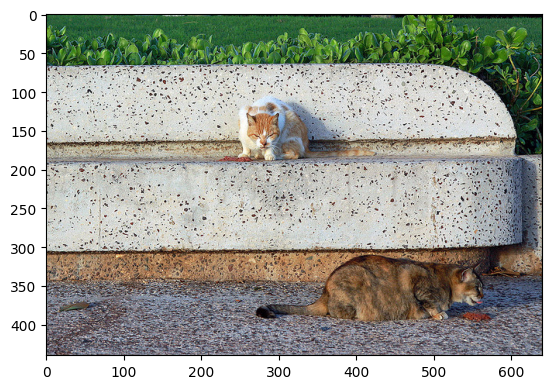

In [30]:
plt.imshow(img)

#### The function will map the data in the format (Image,label) which is aligned with the data format has been used in the part1

In [20]:
def get_data(meta,label, datadir="/scratch/lt2316-h18-resources/coco/train2017"):
    return [{ 'image':Image.open("{}/{}".format(datadir, x['file_name'])).resize((100,100)), 'label':label} for x in meta]

In [21]:
cat_data_train = get_data(cat_meta_train,cat_cat[0])
cat_data_train[0]

{'image': <PIL.Image.Image image mode=RGB size=100x100>, 'label': 17}

In [22]:
len(cat_data_train)

400

In [23]:
type(cat_data_train)

list

In [98]:
horse_data_train = get_data(horse_meta_train,horse_cat[0])
cat_data_test = get_data(cat_meta_test,cat_cat[0])
horse_data_test = get_data(horse_meta_test,horse_cat[0])

In [102]:
cat_data_train

Dataset({
    features: ['image', 'label'],
    num_rows: 400
})

### The train_data format is List
But it should be converted to Dataset to be able to apply the transfrom function on them       
Done!

In [31]:
from datasets import Dataset
cat_data_train=Dataset.from_list(cat_data_train)

In [103]:
horse_data_train = Dataset.from_list(horse_data_train)
cat_data_test = Dataset.from_list(cat_data_test)
horse_data_test = Dataset.from_list(horse_data_test)

In [105]:
cat_data_train

Dataset({
    features: ['image', 'label'],
    num_rows: 400
})

In [52]:
cat_data_train.features["label"]

Value(dtype='int64', id=None)

### After data preparation the steps are:

In [34]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

2023-11-26 00:35:04.024534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [36]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [37]:
cat_data_train= cat_data_train.with_transform(transforms)

In [38]:
type(cat_data_train)

datasets.arrow_dataset.Dataset

### seems we don't need to do this we have the cat_ids and categories 

In [66]:
labels = cat_data_train.features["label"]
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

TypeError: 'Value' object is not iterable

In [79]:
labels =['cat','horse']
type(labels)

list

In [80]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [56]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [57]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [67]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [107]:
cat_data_train = cat_data_train.with_transform(transforms)
cat_data_test=cat_data_test.with_transform(transforms)

In [69]:
cat_data_train.features['image']

Image(decode=True, id=None)

In [70]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [71]:
# pip install  evaluate
# !pip install transformers datasets
# !pip install accelerate -U

In [72]:
import evaluate

accuracy = evaluate.load("accuracy")

In [73]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [81]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
 device = "cpu" 

In [108]:
training_args = TrainingArguments(
    output_dir="my_awesome_coco_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    no_cuda= True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=cat_data_train,
    eval_dataset=cat_data_test,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## <span style="color:red">stoped here </span>

In [94]:
cat_data_train.features

{'image': Image(decode=True, id=None), 'label': Value(dtype='int64', id=None)}

In [109]:
cat_data_test.features

{'image': Image(decode=True, id=None), 'label': Value(dtype='int64', id=None)}

In [33]:
# pip install transformers[torch]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [41]:
model.save_pretrained('.')

In [110]:
from transformers import pipeline
modelPath="/home/gusmankae@GU.GU.SE/my_awesome_coco_model/checkpoint-45"

classifier = pipeline("image-classification", model=modelPath)
classifier(image)

OSError: Can't load the configuration of '/home/gusmankae@GU.GU.SE/my_awesome_coco_model/checkpoint-45'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure '/home/gusmankae@GU.GU.SE/my_awesome_coco_model/checkpoint-45' is the correct path to a directory containing a config.json file

In [63]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained(modelPath)
inputs = image_processor(image, return_tensors="pt")

In [64]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(modelPath)
with torch.no_grad():
    logits = model(**inputs).logits

In [65]:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'beignets'